In [ ]:
from helpers import load_csv_data, create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import batch_iter, sigmoid
from mie import build_poly, build_k_indices, cross_validation, cross_validation_weights, logistic_loss, train_val_split, subsample_class
from performance import accuracy, f1_score

Load data

In [ ]:
x_train_norm = np.load("processed/x_train.npy")
x_test_norm = np.load("processed/x_test.npy")
y_train = np.load("processed/y_train.npy")
test_ids = np.load("processed/test_ids.npy")
train_ids = np.load("processed/train_ids.npy")
important_features = np.load("processed/important_features.npy")    

Logistic regression

In [ ]:
# Split fissa: per valutare performance
#X_train, y_train, X_val, y_val = train_val_split(x_train_norm, y_train, val_ratio=0.2)

# Subsampling only on training set
#X_bal, y_bal = subsample_class(X_train, y_train, target_ratio=0.3)


Cross validation

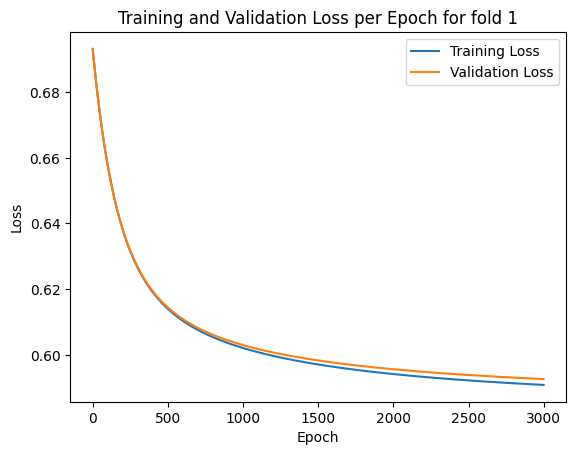

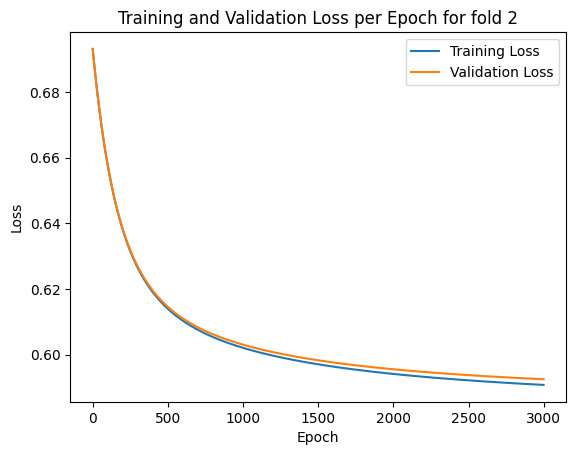

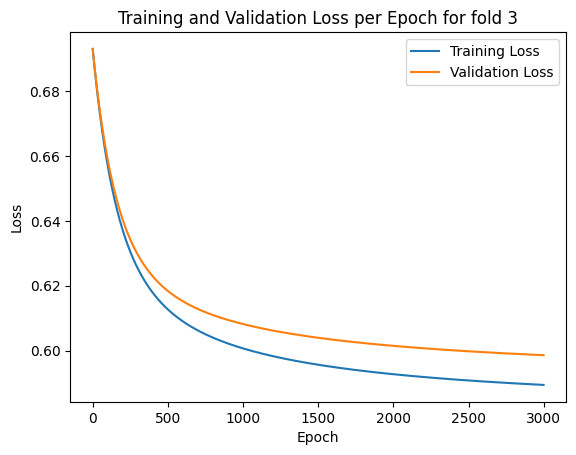

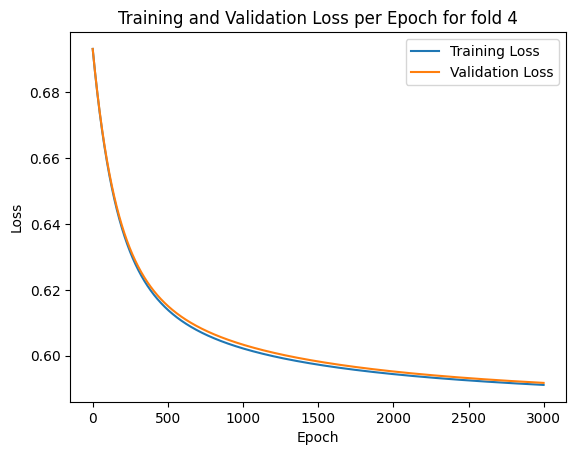

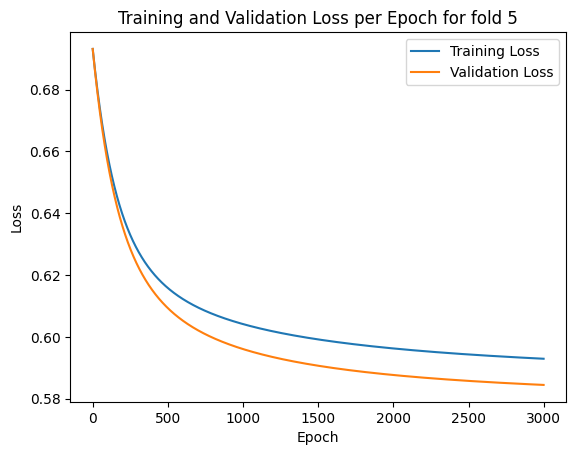

In [ ]:
k_fold=5
k_indices=build_k_indices(y_train, k_fold, seed=42)
loss_val=[]
loss_tr=[]
ws=[]
acc_scores=[]
f1_scores=[]
initial_w = np.zeros((x_train_norm.shape[1], 1))

degrees=np.arange(2,11)
lambdas_arr=np.linspace(0, 0.1, 20)

def best_degree_selection(y, x, gamma, lambdas, degrees, k_fold, seed=1):
    """cross validation over regularisation parameter lambda and degree.

    Args:
        degrees: shape = (d,), where d is the number of degrees to test
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_degree : integer, value of the best degree
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_degree, best_lambda)

    >>> best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
    (7, 0.004520353656360241, 0.28957280566456634)
    """

    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)

    best_lambdas=[]
    best_rmses=[]

    for degree in degrees:
        rmse_tr=[]
        rmse_te=[]
        for lambda_ in lambdas:
            rmse_tr_tmp = []
            rmse_te_tmp = []
            for k in range(k_fold):
                loss_tr, loss_te=cross_validation(y, x, k_indices, k, lambda_, gamma, degree)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            rmse_tr.append(np.mean(rmse_tr_tmp))
            rmse_te.append(np.mean(rmse_te_tmp))

        best_lambdas.append(lambdas[np.argmin(rmse_te)])
        best_rmses.append(rmse_te[np.argmin(rmse_te)])

    ind_best_degree = np.argmin(best_rmses)
    best_degree=degrees[ind_best_degree]
    best_rmse=best_rmses[ind_best_degree]
    best_lambda=best_lambdas[ind_best_degree]
    
    return best_degree, best_lambda, best_rmse

gamma=0.001
#best_deg, best_lambda, best_rmse = best_degree_selection(y_train, X_train, gamma, lambdas_arr, degrees, k_fold, 1)


for k in range(k_fold):
    w, loss_tr_tmp, loss_val_tmp = cross_validation_weights(y_train, x_train_norm, important_features, k_indices, k, initial_w, max_iters=3000, gamma=0.001, lambda_=0.01)
    loss_tr.append(loss_tr_tmp[-1])
    loss_val.append(loss_val_tmp[-1])
    ws.append(w)

    plt.plot(loss_tr_tmp, label='Training Loss')
    plt.plot(loss_val_tmp, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch for fold {k+1}')
    plt.legend()
    plt.show()
   
w_best=np.mean(ws, axis=0)

In [ ]:
y_pred_prob = sigmoid(X_val @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)
acc = accuracy(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
acc_scores.append(acc)
f1_scores.append(f1)
print("Accuracy: ", acc)
print("F1: ", f1)

Accuracy:  0.5544343560739511
F1:  0.14892786210097173


Test

In [ ]:
y_pred_prob = sigmoid(x_test_norm @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)

#create_csv_submission(test_ids, y_pred, 'Reg_Logistic_1')